### Data preprocessing

In [1]:
# Import necessary libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from scipy.stats import chi2_contingency
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import files
downloaded = drive.CreateFile({'id':'1AUw42_tedl0uoohAbEnyRFJRyh8wCF9V'}) 
downloaded.GetContentFile('winemag-data_first150k.csv')  
downloaded2 = drive.CreateFile({'id':'1lhCL_2kLnPoOf-rtsi_n0Pb10qBm_VXm'}) 
downloaded2.GetContentFile('winemag-data-130k-v2.csv') 

In [2]:
# Retrieve data into dataframe
data = pd.read_csv('winemag-data-130k-v2.csv')
data2 = pd.read_csv('winemag-data_first150k.csv')

# Filter for US data
data = data[data['variety'].notna()]
data = data[data['country'] == 'US']

data2 = data2[data2['variety'].notna()]
data2 = data2[data2['country'] == 'US']

## Join the data together
data = data.append(data2)

In [3]:
# Dropping duplicated rows and rows with duplicated descriptions
data.drop_duplicates(inplace=True)
data = data.drop_duplicates(subset=['description'])

In [5]:
# To be removed
# Checking through top 20 wine review descriptions are all different
# data['review_length'] = data['description'].str.split().str.len()
# data.nlargest(20, 'review_length')['description']
# print(data.iloc[26672]['description'])
# data.nunique()
# data.describe()
# data.info()

The data has been further zoomed in to wine varieties with more than 1000 wine reviews from sommeliers. According to the University of Alabama, a minimum of 1000 samples are needed for each class in machine learning.

https://sites.uab.edu/periop-datascience/2021/06/28/sample-size-in-machine-learning-and-artificial-intelligence/#:~:text=If%20you%27ve%20talked%20with,least%201%2C000%20samples%20per%20class

In [4]:
# Filtering out wine varieties with only > 1000 reviews

data = data[data['variety'].isin(data['variety'].value_counts()[data['variety'].value_counts()>1000].index)]

In [5]:
#one hot encoding
cat_vars = ['province', 'region_1', 'region_2', 'variety', 'winery']

province_unique = data['province'].unique()
region_1_unique = data['region_1'].unique()
region_2_unique = data['region_2'].unique()
variety_unique = data['variety'].unique()

for variable in province_unique:
  data[variable] = data['province'].apply(lambda x: 1 if x == variable else 0)

for variable in region_1_unique:
  data[variable] = data['region_1'].apply(lambda x: 1 if x == variable else 0)

for variable in region_2_unique:
  data[variable] = data['region_2'].apply(lambda x: 1 if x == variable else 0)

for variable in variety_unique:
  data[variable] = data['variety'].apply(lambda x: 1 if x == variable else 0)

In [6]:
#Remove wine names from the descriptions
data['description'] = data['description'].str.lower()
for name in variety_unique:
  data['description'] = data['description'].apply(lambda x: x.replace(name.lower(), ""))
  

The wine varieties were removed from the word descriptions, as they are directly correlated features tot he target variable. This was to prevent data biasness and data leakage and spillover. Additionally, some descriptions compared wines against other varieties, and hence mentioned. As such, all wine varieties in descriptions were removed.

In [7]:
# Creating new column "des" as a stack of description, province, region and winery
data['des'] = data[['description', 'province', 'region_1']].apply(lambda x: " ".join(x.astype(str)), axis=1)

In [8]:
#Assigning variety class
data['class'] = pd.factorize(data['variety'])[0]

Fixing the skewness of the data by adjusting the number of reviews per wine variety.

In [9]:
data['variety'].value_counts()

Pinot Noir                  12302
Cabernet Sauvignon           9979
Chardonnay                   8860
Syrah                        4476
Zinfandel                    3797
Red Blend                    3796
Merlot                       3474
Sauvignon Blanc              2936
Bordeaux-style Red Blend     2293
Riesling                     2060
Cabernet Franc               1237
Viognier                     1093
Pinot Gris                   1026
Rosé                         1018
Name: variety, dtype: int64

In [10]:
#We will downsample all classes to hit 1000 wine reviews. This greatly decreases our total value counts to only 14,000 rows.


from sklearn.utils import resample
array = []
for variety in variety_unique:
    array.append(resample(data[data['variety'] == variety], replace=False, n_samples= 1000, random_state=42))

In [11]:
data = pd.concat(array)
data = data.sample(frac = 1, random_state = 42).reset_index()

In [12]:
#Test again to check the skewness
data['variety'].value_counts()


Cabernet Franc              1000
Zinfandel                   1000
Viognier                    1000
Pinot Noir                  1000
Chardonnay                  1000
Pinot Gris                  1000
Bordeaux-style Red Blend    1000
Merlot                      1000
Riesling                    1000
Rosé                        1000
Sauvignon Blanc             1000
Cabernet Sauvignon          1000
Syrah                       1000
Red Blend                   1000
Name: variety, dtype: int64

Data processing was done with the followng steps:

1. Combining both datasets pulled from the wine reviews
2. Filtering reviews to only be from the US
3. Cleaning - removing duplicate cells and wine descriptions
4. Filtering only wine varieties with > 1000 reviews
5. Feature Engineering - "des"
6. One hot encoding for categorical variables
7. Remove wine names from the descriptions


# EDA

Text(0, 0.5, 'Variety')

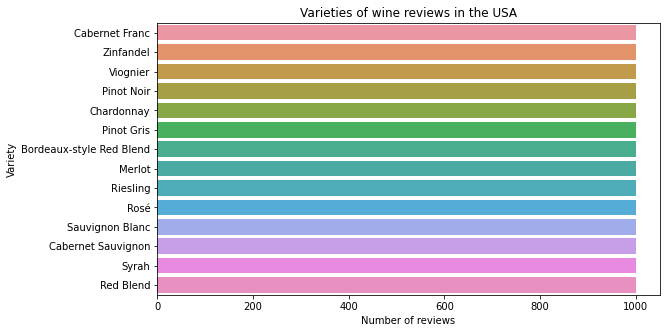

In [13]:
#Plot of frequencies of varities of wine

variety_order= data['variety'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data = data,y='variety', order = variety_order)
plt.title('Varieties of wine reviews in the USA')
plt.xlabel('Number of reviews')
plt.ylabel('Variety')

In [14]:
unique_varieties = data['variety'].unique()
unique_varieties

array(['Pinot Noir', 'Cabernet Sauvignon', 'Cabernet Franc',
       'Sauvignon Blanc', 'Zinfandel', 'Red Blend', 'Rosé', 'Chardonnay',
       'Viognier', 'Pinot Gris', 'Merlot', 'Syrah', 'Riesling',
       'Bordeaux-style Red Blend'], dtype=object)

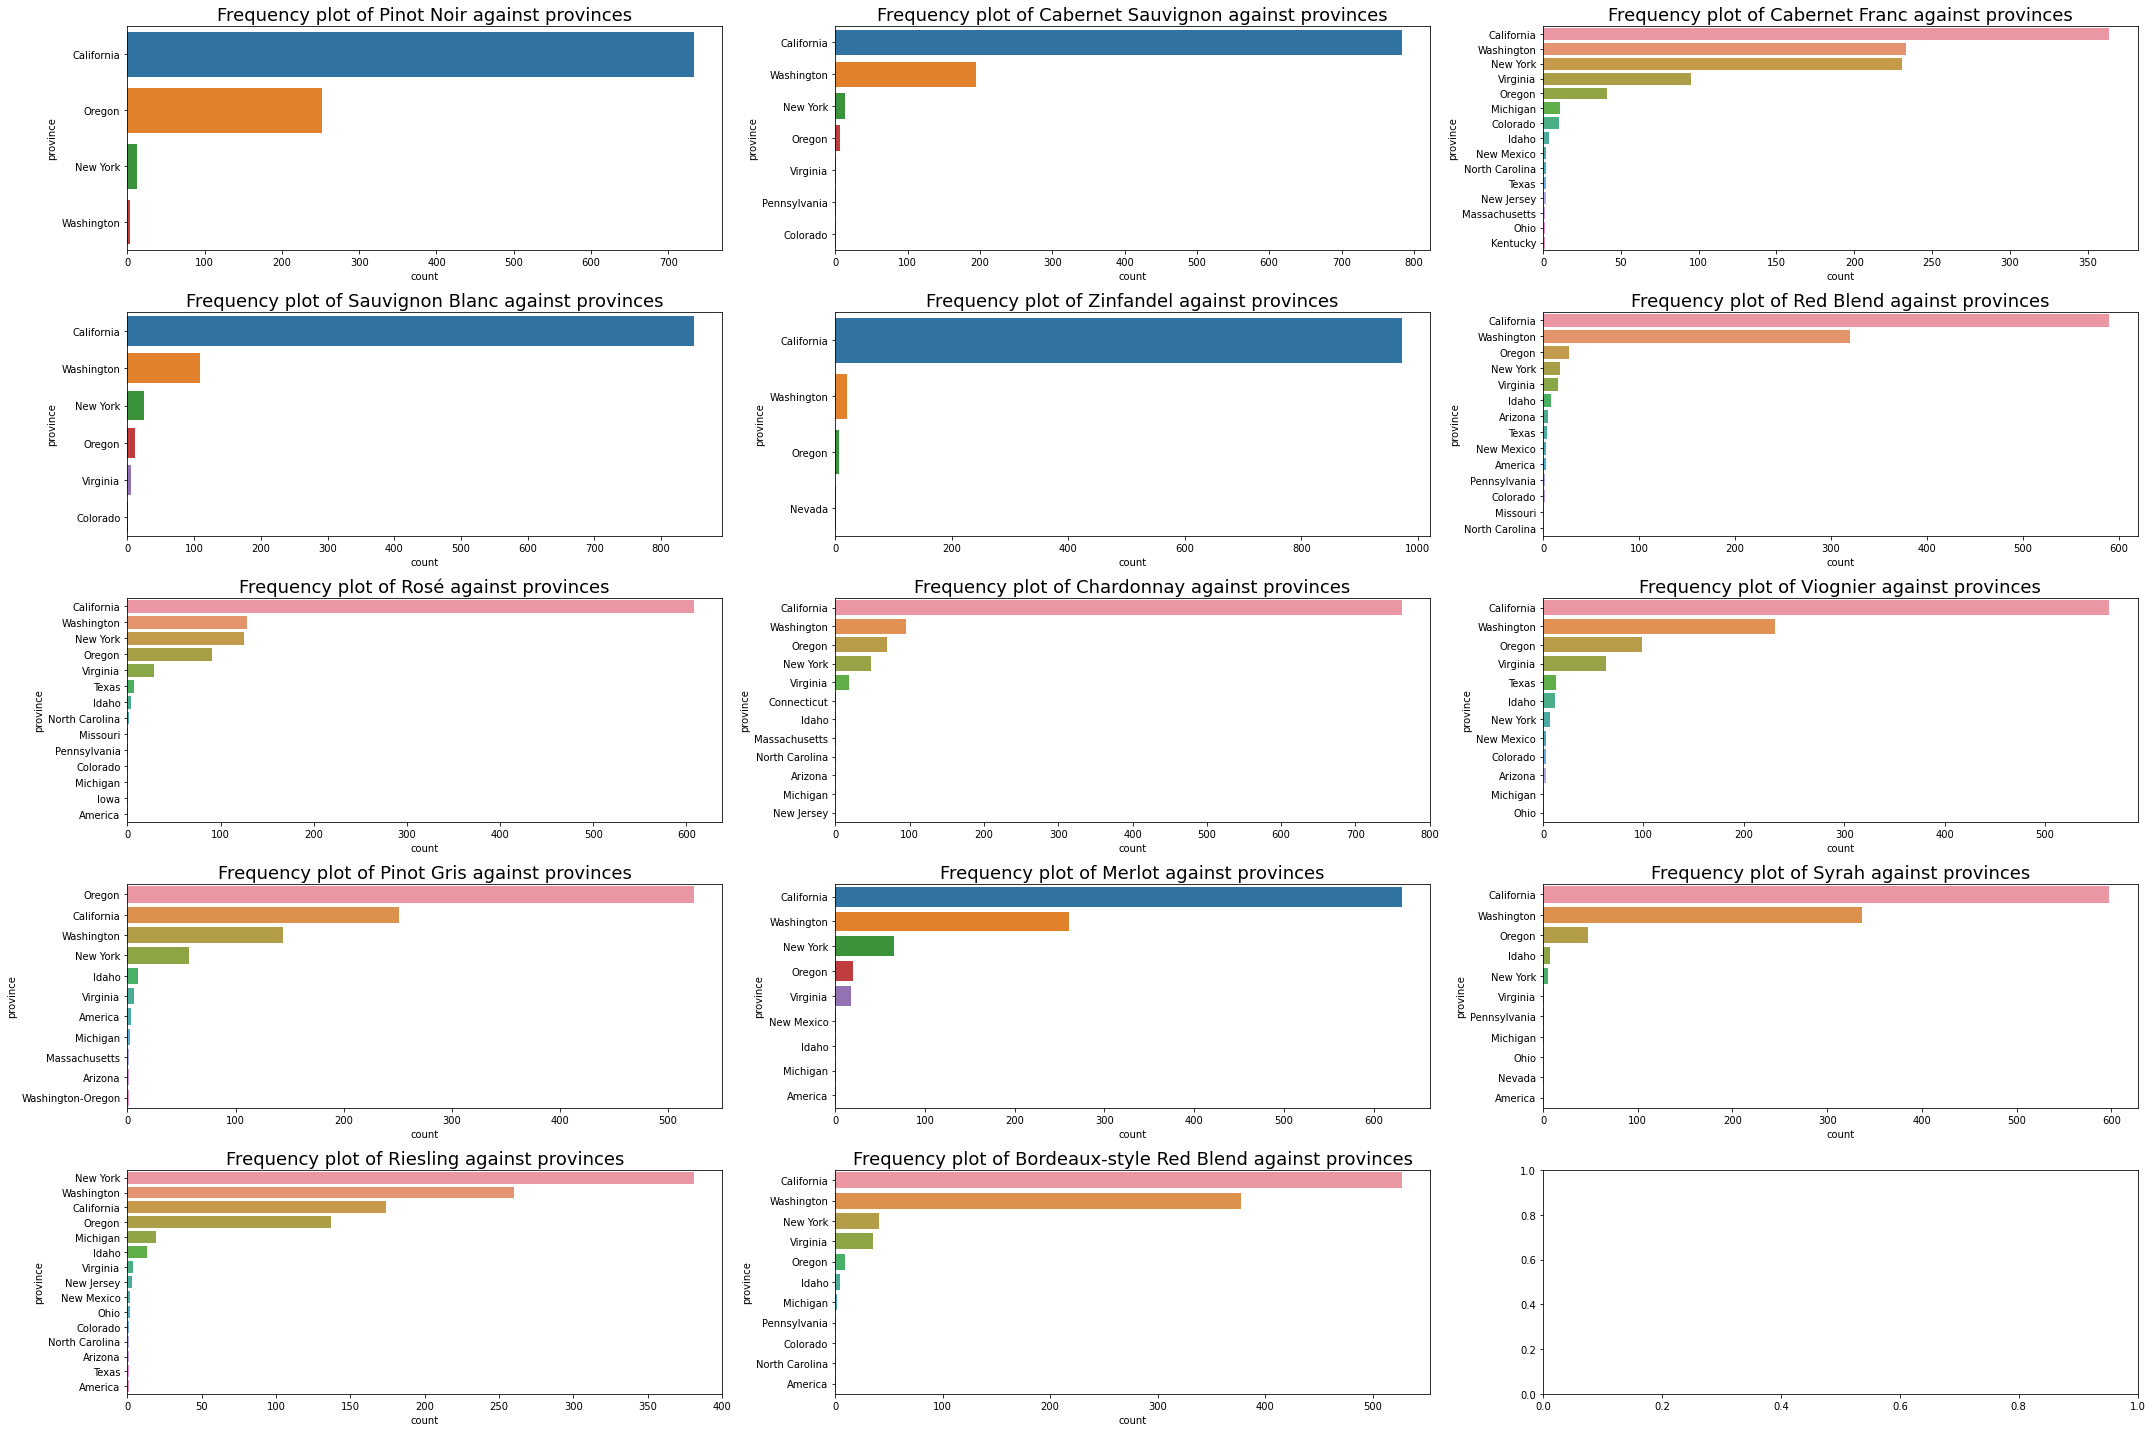

In [71]:
from scipy.special import zeta
fig, axes = plt.subplots(5, 3, figsize=(30, 20))
x = 0
z = 0

for variety in unique_varieties:
  data_filtered = data[data['variety'] == variety]
  order = data_filtered['province'].value_counts().index
  sns.countplot(ax = axes[z,x], data = data_filtered, y = 'province', order = order )
  axes[z,x].set_title("Frequency plot of {} against provinces".format(variety), fontsize = '18')
  x += 1
  if x == 3:
    x = 0
    z += 1
plt.tight_layout()

In [16]:
#Get p value for chi square tests
p_value_cat_vars = []
chi_cat_vars = []
for var in cat_vars:
  if var != 'variety':
    chi_cat_vars.append(var)
    info = pd.crosstab(data[var].to_numpy(), data['variety'].to_numpy())
    stat, p, dof, expected = chi2_contingency(info)
    p_value_cat_vars.append(p)

print("Chi square test on province region and winery against variety of wines")
pd.DataFrame(p_value_cat_vars, index=chi_cat_vars)

Chi square test on province region and winery against variety of wines


,0
province,0.0
region_1,0.0
region_2,0.0
winery,0.0


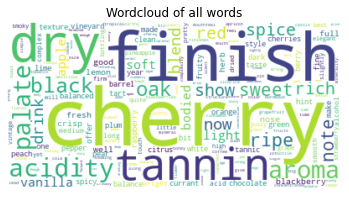

In [17]:
#Word cloud for all words
total_text = ""
for cat in data['description']:
  total_text += cat

for w in unique_varieties:
  STOPWORDS.add(w.lower())
STOPWORDS.add('flavor')
STOPWORDS.add('wine')
STOPWORDS.add('flavors')
STOPWORDS.add('fruit')
stopwords = set(STOPWORDS)

word_cloud = WordCloud(collocations = False, background_color = 'white', stopwords=stopwords).generate(total_text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title("Wordcloud of all words")
plt.axis("off")
plt.show()

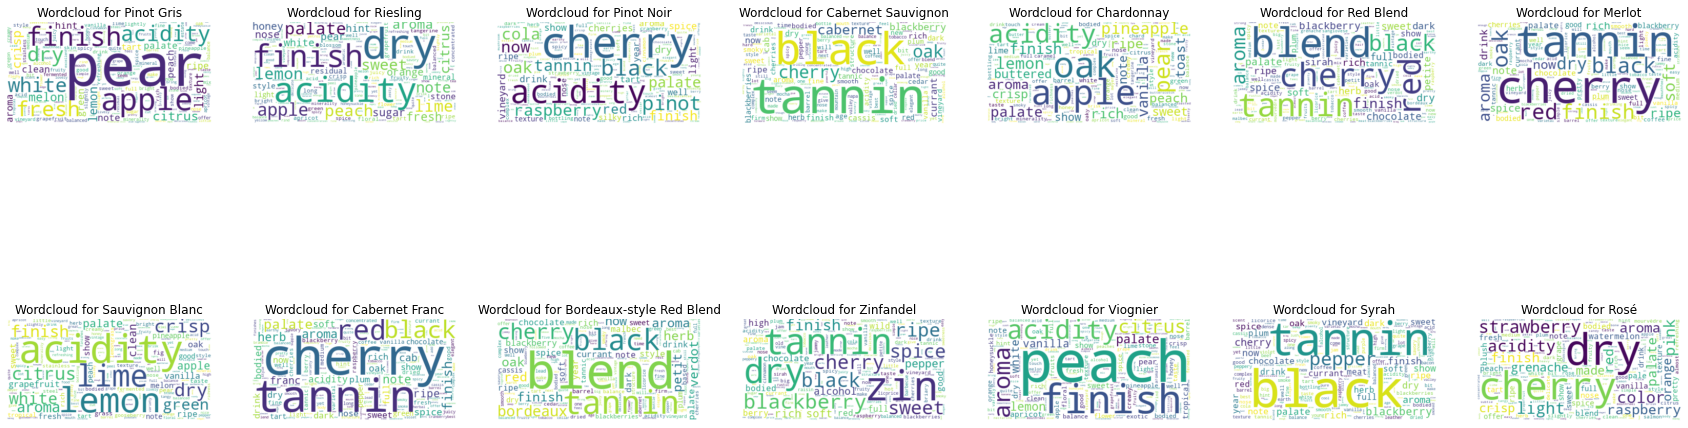

In [18]:
#check per variety 
plot = 0
plt.figure(figsize = (30,10))
for variety_var in variety_unique:
  #initialize the words per variety
  variety_total_text = ""
  variety_var_words = data[data[variety_var] == 1]['description']
  for cat in variety_var_words:
    variety_total_text += cat

  #to add masking for fun
  #mask = np.array(Image.open("/content/Work")) 
  word_cloud = WordCloud(collocations = False, background_color = 'white', stopwords=stopwords).generate(variety_total_text)
  # Display the generated Word Cloud
  plt.subplot(2,7,plot + 1)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.title("Wordcloud for {}".format(variety_var))
  plt.axis("off")
  plot += 1
  
plt.show()

Text(0, 0.5, 'Taster')

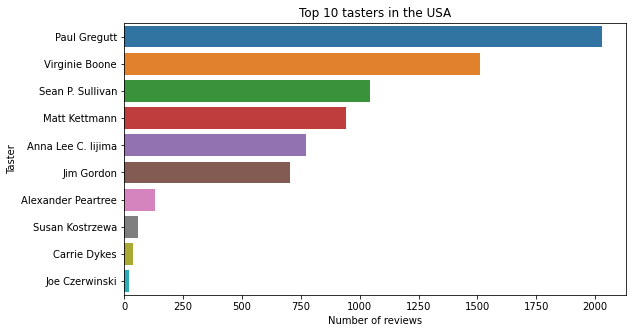

In [19]:
#Name of the top 10 tasters
taster_order= data['taster_name'].value_counts().head(10).index
plt.figure(figsize=(9, 5))
sns.countplot(data = data,y='taster_name', order = taster_order)
plt.title('Top 10 tasters in the USA')
plt.xlabel('Number of reviews')
plt.ylabel('Taster')

Total number of reviews done by the top 6 tasters is 7005 


Text(0, 0.5, 'Points')

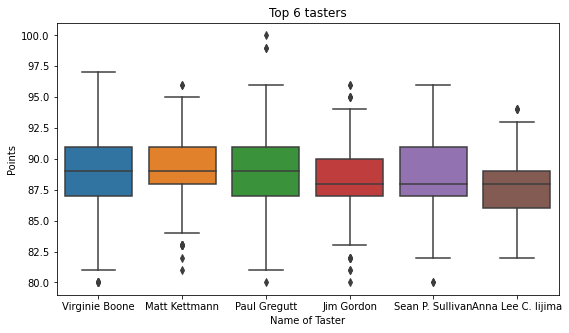

In [20]:
top_6_taster_names = data['taster_name'].value_counts().head(6).index.tolist()
top_6 = data[data['taster_name'].isin(top_6_taster_names)]
print(f"Total number of reviews done by the top 6 tasters is {len(top_6)} ")

#Plot the box plots of the points awarded by each taster

plt.figure(figsize=(9, 5))
sns.boxplot(x="taster_name", y="points", data=top_6)
plt.title("Top 6 tasters")
plt.xlabel("Name of Taster")
plt.ylabel("Points")
 

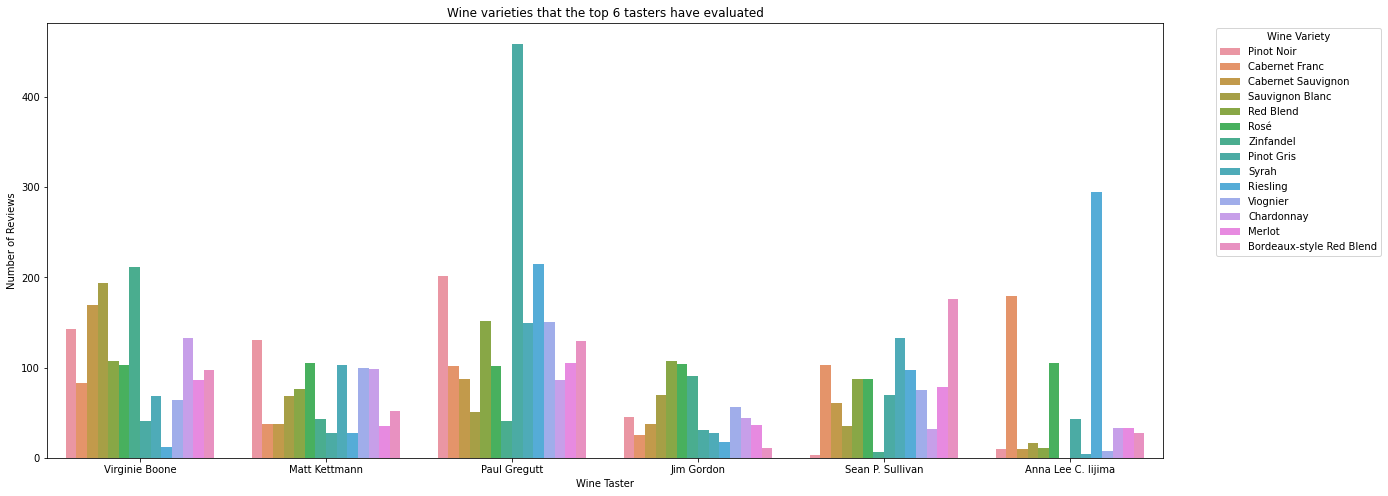

In [21]:
#Bar plot of top 6 tasters with wine variety
plt.figure(figsize=(20, 8))
plot = sns.countplot(data = top_6, x = 'taster_name', hue = 'variety')
plt.title('Wine varieties that the top 6 tasters have evaluated')
plt.xlabel('Wine Taster')
plt.ylabel('Number of Reviews')
plot.legend(title = "Wine Variety", loc = 'upper right', bbox_to_anchor=(0.5, 0.5, 0.7, 0.5))
plt.show()

## Summary of findings



Wine Tasters tend to review a certain wine more than other wines. Points given by wine tasters are also not biased, As such, due to the hypothesis, the taster name is not relevant to our models.

# Feature engineering

In [22]:
# move to the top
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
def text_clean(corpus, keep_list):

    cleaned_corpus = pd.Series()
    for row in corpus:
        qs = []
        for word in row.split():
            if word not in keep_list:
                p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
                p1 = p1.lower()
                qs.append(p1)
            else : qs.append(word)
        cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
    return cleaned_corpus


def lemmatize(corpus):
    lem = WordNetLemmatizer()
    corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    return corpus

def stem(corpus):
    stemmer = PorterStemmer()
    corpus = [[stemmer.stem(x) for x in x] for x in corpus]
    return corpus

def stopwords_removal(corpus):
    stop = set(STOPWORDS)
    corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    corpus = [' '.join(x) for x in corpus] 
    return corpus

def preprocess(corpus, keep_list):
    corpus = text_clean(corpus, keep_list)
    corpus = stopwords_removal(corpus)
    corpus = lemmatize(corpus)     
    corpus = stem(corpus)
    corpus = [''.join(x) for x in corpus]       
    return corpus

preprocessed_corpus = preprocess(data['des'], keep_list = [])

In [24]:
data['des'].iloc[0]

'blue fruit and high acidity open this delightful , from a cool section of the russian river valley overlapping green valley. the oak imprint is low, yet the wine offers firm structure and elegance, remaining subdued and fresh on the palate in swirls of dark cherry, boysenberry and earthy leather. California Russian River Valley'

In [25]:
data['processed'] = preprocessed_corpus

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data['processed'], data['variety'], stratify=data['variety'], test_size = 0.20, random_state = 42)

In [27]:
# tokenize the news text and convert data in matrix format
vectorizer = CountVectorizer(stop_words='english')
X_vec_train = vectorizer.fit_transform(X_train)
X_vec_test = vectorizer.transform(X_test)

In [28]:
# Transform data by applying term frequency inverse document frequency (TF-IDF) 
tfidf = TfidfTransformer() 
X_tfidf_train = tfidf.fit_transform(X_vec_train)
X_tfidf_test = tfidf.transform(X_vec_test)

# Model Creation

In [29]:
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier

import sklearn.metrics as metrics

In [34]:
%%time
# Grid Search for SVM

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear','polynomial']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

svc = SVC(probability = True)
clf = GridSearchCV(svc, param_grid)
clf.fit(X_tfidf_train[0:1000], y_train[0:1000])

print(clf.best_params_)

{'C': 1, 'kernel': 'linear'}
CPU times: user 1min 18s, sys: 72.9 ms, total: 1min 18s
Wall time: 1min 21s


In [35]:
%%time
# Grid Search for Logistic Regression
param_grid = [
  {'solver':['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty':['l1','l2'], 'Cs' :[1, 10]},
]
  

lg = LogisticRegressionCV(multi_class='multinomial')
clf = GridSearchCV(lg, param_grid)
clf.fit(X_tfidf_train[0:1000], y_train[0:1000])

print(clf.best_params_)

{'Cs': 10, 'penalty': 'l1', 'solver': 'saga'}
CPU times: user 19min 41s, sys: 3min 21s, total: 23min 3s
Wall time: 19min 26s


In [55]:
%%time
# Grid search for Random Forest
param_grid = [
  {'min_samples_split':[2,5,10,30,50], 'max_depth': [10, 50, 100, None], 'ccp_alpha': [0, 0.005, 0.01], 
   'min_samples_leaf': [2,5,10,30,50]},
 ] 



rf = RandomForestClassifier(oob_score = True)
clf = GridSearchCV(rf, param_grid)
clf.fit(X_tfidf_train[0:1000], y_train[0:1000])

print(clf.best_params_)

{'ccp_alpha': 0, 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 50}
CPU times: user 5min 5s, sys: 1.53 s, total: 5min 7s
Wall time: 5min 7s


## Model Training

In [30]:
recall_pd = pd.DataFrame()
prec_pd = pd.DataFrame()
acc_pd = pd.DataFrame()

In [31]:
enc = OneHotEncoder()
enc.fit(np.array(y_train).reshape(-1, 1))
y_test_arr = enc.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [32]:
def get_prec_recall(confusion_matrix, model_name):
    recall_lst = []
    prec_lst = []
    for i in range(0,14):
        prec = confusion_matrix[i][i] / sum([row[i] for row in confusion_matrix])
        recall = confusion_matrix[i][i] / sum(confusion_matrix[i])
        recall_lst.append(recall)
        prec_lst.append(recall)
    recall_pd[model_name] = recall_lst
    prec_pd[model_name] = prec_lst
    acc_pd[model_name] = [metrics.accuracy_score(y_test, y_pred)]

In [33]:
svc = SVC(kernel = 'linear', C = 1, probability = True)
lg = LogisticRegressionCV(multi_class='multinomial', solver = 'saga', penalty = 'l1', Cs = 10)
rf = RandomForestClassifier(oob_score = True, ccp_alpha = 0, max_depth = 50, min_samples_split = 50, min_samples_leaf = 2)
nb = MultinomialNB()

### SVM

In [35]:
# SVC
svc = SVC(kernel = 'linear', C = 1, probability = True)
svc.fit(X_tfidf_train, y_train)
y_pred = svc.predict(X_tfidf_test)
print(classification_report(y_test,y_pred, labels = variety_unique))
matrix = metrics.confusion_matrix(y_test, y_pred, labels = variety_unique)
print(matrix)
get_prec_recall(matrix, "SVM")

                          precision    recall  f1-score   support

              Pinot Gris       0.67      0.65      0.66       200
                Riesling       0.76      0.79      0.77       200
              Pinot Noir       0.80      0.86      0.83       200
      Cabernet Sauvignon       0.60      0.58      0.59       200
              Chardonnay       0.65      0.69      0.67       200
               Red Blend       0.61      0.53      0.56       200
                  Merlot       0.37      0.45      0.40       200
         Sauvignon Blanc       0.70      0.65      0.67       200
          Cabernet Franc       0.56      0.58      0.57       200
Bordeaux-style Red Blend       0.72      0.62      0.67       200
               Zinfandel       0.69      0.67      0.68       200
                Viognier       0.63      0.65      0.64       200
                   Syrah       0.52      0.53      0.52       200
                    Rosé       0.85      0.80      0.82       200

        

In [36]:
%%time
svc.predict(X_tfidf_test)

CPU times: total: 5.86 s
Wall time: 5.86 s


array(['Syrah', 'Chardonnay', 'Viognier', ..., 'Viognier',
       'Bordeaux-style Red Blend', 'Rosé'], dtype=object)

AUC_ROC: 0.9448613226059657


Text(0, 0.5, 'True Positive Rate')

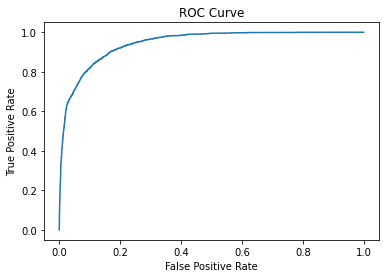

In [37]:
# ROC_Curve
y_score = svc.decision_function(X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"],tpr["micro"])
print("AUC_ROC:", roc_auc["micro"])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Logistic Regression

In [38]:
# Logistic Regression
lg = LogisticRegressionCV(multi_class='multinomial', solver = 'saga', penalty = 'l1', Cs = 10)
lg.fit(X_tfidf_train, y_train)
y_pred = lg.predict(X_tfidf_test)
print(classification_report(y_test,y_pred, labels = variety_unique))
matrix = metrics.confusion_matrix(y_test, y_pred, labels = variety_unique)
print(matrix)
get_prec_recall(matrix, "Logistic Regression")

                          precision    recall  f1-score   support

              Pinot Gris       0.62      0.63      0.63       200
                Riesling       0.78      0.73      0.76       200
              Pinot Noir       0.78      0.83      0.80       200
      Cabernet Sauvignon       0.61      0.54      0.57       200
              Chardonnay       0.67      0.68      0.67       200
               Red Blend       0.57      0.53      0.55       200
                  Merlot       0.38      0.41      0.39       200
         Sauvignon Blanc       0.68      0.68      0.68       200
          Cabernet Franc       0.55      0.56      0.56       200
Bordeaux-style Red Blend       0.67      0.60      0.63       200
               Zinfandel       0.67      0.69      0.68       200
                Viognier       0.61      0.68      0.64       200
                   Syrah       0.53      0.54      0.53       200
                    Rosé       0.81      0.80      0.80       200

        

In [39]:
%%time
lg.predict(X_tfidf_test)

CPU times: total: 31.2 ms
Wall time: 3.99 ms


array(['Merlot', 'Chardonnay', 'Viognier', ..., 'Viognier', 'Red Blend',
       'Rosé'], dtype=object)

AUC_ROC: 0.9124873626373626


Text(0, 0.5, 'True Positive Rate')

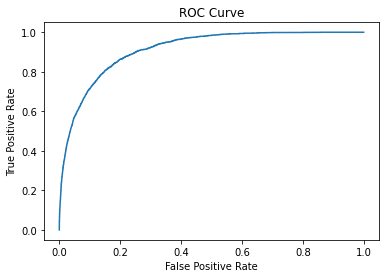

In [40]:
## ROC Curve
y_score = lg.decision_function(X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"],tpr["micro"])
print("AUC_ROC:", roc_auc["micro"])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Random Forest

In [41]:
# Random forest
rf = RandomForestClassifier(oob_score = True, ccp_alpha = 0, max_depth = 50, min_samples_split = 50, min_samples_leaf = 2)
rf.fit(X_tfidf_train, y_train)
y_pred = rf.predict(X_tfidf_test)
print(classification_report(y_test,y_pred, labels = variety_unique))
matrix = metrics.confusion_matrix(y_test, y_pred, labels = variety_unique)
print(matrix)
get_prec_recall(matrix, "Random Forest")

                          precision    recall  f1-score   support

              Pinot Gris       0.59      0.61      0.60       200
                Riesling       0.72      0.71      0.72       200
              Pinot Noir       0.72      0.82      0.77       200
      Cabernet Sauvignon       0.50      0.56      0.53       200
              Chardonnay       0.64      0.64      0.64       200
               Red Blend       0.61      0.35      0.44       200
                  Merlot       0.47      0.33      0.39       200
         Sauvignon Blanc       0.59      0.71      0.64       200
          Cabernet Franc       0.60      0.53      0.56       200
Bordeaux-style Red Blend       0.60      0.69      0.64       200
               Zinfandel       0.58      0.74      0.65       200
                Viognier       0.59      0.57      0.58       200
                   Syrah       0.49      0.43      0.46       200
                    Rosé       0.74      0.78      0.76       200

        

In [42]:
%%time
rf.predict(X_tfidf_test)

CPU times: total: 62.5 ms
Wall time: 66.8 ms


array(['Merlot', 'Chardonnay', 'Viognier', ..., 'Viognier',
       'Bordeaux-style Red Blend', 'Rosé'], dtype=object)

AUC_ROC: 0.9393298861852433


Text(0, 0.5, 'True Positive Rate')

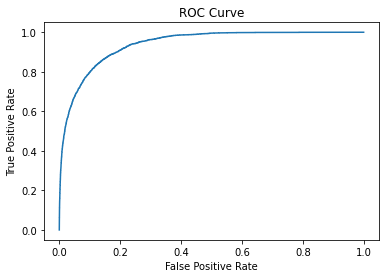

In [43]:
# ROC Curve
y_score = rf.predict_proba(X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"],tpr["micro"])
print("AUC_ROC:", roc_auc["micro"])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Naive Bayes

In [44]:
#Bayes Classifier
nb = MultinomialNB()
nb.fit(X_tfidf_train, y_train)
y_pred = nb.predict(X_tfidf_test)
print(classification_report(y_test,y_pred, labels = variety_unique))
matrix = metrics.confusion_matrix(y_test, y_pred, labels = variety_unique)
print(matrix)
get_prec_recall(matrix, "Naive Bayes")

                          precision    recall  f1-score   support

              Pinot Gris       0.60      0.62      0.61       200
                Riesling       0.69      0.73      0.71       200
              Pinot Noir       0.79      0.83      0.81       200
      Cabernet Sauvignon       0.44      0.46      0.45       200
              Chardonnay       0.61      0.62      0.62       200
               Red Blend       0.59      0.40      0.48       200
                  Merlot       0.36      0.27      0.31       200
         Sauvignon Blanc       0.66      0.68      0.67       200
          Cabernet Franc       0.47      0.48      0.48       200
Bordeaux-style Red Blend       0.48      0.68      0.56       200
               Zinfandel       0.55      0.70      0.62       200
                Viognier       0.59      0.56      0.58       200
                   Syrah       0.54      0.42      0.47       200
                    Rosé       0.81      0.74      0.77       200

        

In [45]:
%%time
nb.predict(X_tfidf_test)

CPU times: total: 0 ns
Wall time: 1.99 ms


array(['Bordeaux-style Red Blend', 'Sauvignon Blanc', 'Viognier', ...,
       'Sauvignon Blanc', 'Bordeaux-style Red Blend', 'Rosé'],
      dtype='<U24')

AUC_ROC: 0.9390876864207223


Text(0, 0.5, 'True Positive Rate')

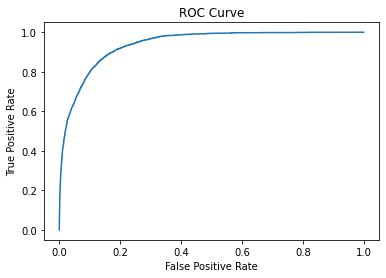

In [46]:
# ROC Curve
y_score = nb.predict_proba(X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"],tpr["micro"])
print("AUC_ROC:", roc_auc["micro"])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Voting Classifier

In [47]:
#Ensemble Classifier
voting_clf = VotingClassifier(estimators=[('lr', lg), ('rf', rf), ('svc', svc), ('bayes', nb)], voting='soft')
voting_clf.fit(X_tfidf_train, y_train)
y_pred = voting_clf.predict(X_tfidf_test)
print(classification_report(y_test,y_pred, labels = variety_unique))
matrix = metrics.confusion_matrix(y_test, y_pred, labels = variety_unique)
print(matrix)
get_prec_recall(matrix, "Voting Classifier")

                          precision    recall  f1-score   support

              Pinot Gris       0.66      0.64      0.65       200
                Riesling       0.76      0.78      0.77       200
              Pinot Noir       0.80      0.86      0.83       200
      Cabernet Sauvignon       0.60      0.59      0.60       200
              Chardonnay       0.66      0.69      0.67       200
               Red Blend       0.61      0.53      0.56       200
                  Merlot       0.38      0.39      0.38       200
         Sauvignon Blanc       0.69      0.69      0.69       200
          Cabernet Franc       0.58      0.56      0.57       200
Bordeaux-style Red Blend       0.68      0.66      0.66       200
               Zinfandel       0.67      0.69      0.68       200
                Viognier       0.64      0.68      0.66       200
                   Syrah       0.56      0.56      0.56       200
                    Rosé       0.83      0.82      0.83       200

        

In [48]:
%%time
voting_clf.predict(X_tfidf_test)

CPU times: total: 5.95 s
Wall time: 5.95 s


array(['Syrah', 'Chardonnay', 'Viognier', ..., 'Viognier',
       'Bordeaux-style Red Blend', 'Rosé'], dtype=object)

AUC_ROC: 0.9582869309262168


Text(0, 0.5, 'True Positive Rate')

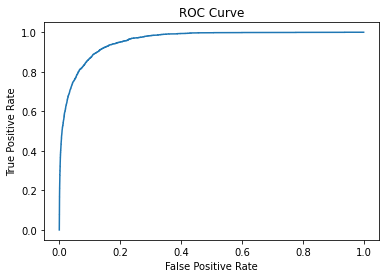

In [49]:
# ROC Curve
y_score = voting_clf.predict_proba(X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"],tpr["micro"])
print("AUC_ROC:", roc_auc["micro"])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Stacking Classifier

In [34]:
#Stacking Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

param_grid = [
  {'cv':[2,5,10], 'stack_method': ['predict_proba', 'decision_function', 'predict']},
 ] 

level0 = list()
level0.append(('lr', lg))
level0.append(('rf', rf))
level0.append(('svc', svc))
level0.append(('bayes', nb))
level1 = LogisticRegression()

sf = StackingClassifier(estimators=level0, final_estimator=level1)
clf = GridSearchCV(sf, param_grid)
clf.fit(X_tfidf_train[0:1000], y_train[0:1000])

print(clf.best_params_)

{'cv': 5, 'stack_method': 'predict_proba'}


In [50]:
sf = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, stack_method='predict_proba')
sf.fit(X_tfidf_train, y_train)
y_pred = sf.predict(X_tfidf_test)
print(classification_report(y_test,y_pred, labels = variety_unique))
matrix = metrics.confusion_matrix(y_test, y_pred, labels = variety_unique)
print(matrix)
get_prec_recall(matrix, "Stacking Classifier")

                          precision    recall  f1-score   support

              Pinot Gris       0.65      0.63      0.64       200
                Riesling       0.80      0.75      0.77       200
              Pinot Noir       0.80      0.86      0.83       200
      Cabernet Sauvignon       0.61      0.56      0.59       200
              Chardonnay       0.68      0.69      0.68       200
               Red Blend       0.61      0.56      0.58       200
                  Merlot       0.36      0.42      0.39       200
         Sauvignon Blanc       0.69      0.69      0.69       200
          Cabernet Franc       0.60      0.56      0.58       200
Bordeaux-style Red Blend       0.71      0.66      0.68       200
               Zinfandel       0.71      0.70      0.70       200
                Viognier       0.64      0.71      0.67       200
                   Syrah       0.55      0.56      0.55       200
                    Rosé       0.85      0.84      0.84       200

        

In [51]:
%%time
sf.predict(X_tfidf_test)

CPU times: total: 5.94 s
Wall time: 5.95 s


array(['Syrah', 'Chardonnay', 'Viognier', ..., 'Viognier',
       'Bordeaux-style Red Blend', 'Rosé'], dtype=object)

AUC_ROC: 0.9590343504709576


Text(0, 0.5, 'True Positive Rate')

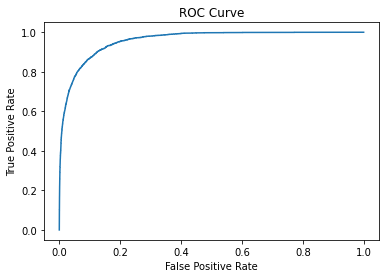

In [52]:
# ROC Curve
y_score = sf.predict_proba(X_tfidf_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"],tpr["micro"])
print("AUC_ROC:", roc_auc["micro"])
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [53]:
recall_pd.index = variety_unique
prec_pd.index = variety_unique

In [54]:
# Recall Rate of all the models
recall_pd

,SVM,Logistic Regression,Random Forest,Naive Bayes,Voting Classifier,Stacking Classifier
Pinot Gris,0.645,0.630,0.615,0.625,0.640,0.630
Riesling,0.790,0.735,0.715,0.735,0.780,0.750
Pinot Noir,0.860,0.835,0.820,0.830,0.860,0.865
Cabernet Sauvignon,0.580,0.540,0.560,0.460,0.590,0.565
Chardonnay,0.695,0.675,0.640,0.620,0.685,0.690
Red Blend,0.525,0.530,0.350,0.400,0.525,0.560
Merlot,0.445,0.410,0.330,0.265,0.385,0.425
Sauvignon Blanc,0.650,0.680,0.710,0.675,0.695,0.695
Cabernet Franc,0.580,0.565,0.525,0.485,0.565,0.565
Bordeaux-style Red Blend,0.625,0.600,0.695,0.675,0.655,0.655


In [55]:
# Precision Rate of all the models
prec_pd

,SVM,Logistic Regression,Random Forest,Naive Bayes,Voting Classifier,Stacking Classifier
Pinot Gris,0.645,0.630,0.615,0.625,0.640,0.630
Riesling,0.790,0.735,0.715,0.735,0.780,0.750
Pinot Noir,0.860,0.835,0.820,0.830,0.860,0.865
Cabernet Sauvignon,0.580,0.540,0.560,0.460,0.590,0.565
Chardonnay,0.695,0.675,0.640,0.620,0.685,0.690
Red Blend,0.525,0.530,0.350,0.400,0.525,0.560
Merlot,0.445,0.410,0.330,0.265,0.385,0.425
Sauvignon Blanc,0.650,0.680,0.710,0.675,0.695,0.695
Cabernet Franc,0.580,0.565,0.525,0.485,0.565,0.565
Bordeaux-style Red Blend,0.625,0.600,0.695,0.675,0.655,0.655


In [56]:
#Accuracy Rate of all models
acc_pd

,SVM,Logistic Regression,Random Forest,Naive Bayes,Voting Classifier,Stacking Classifier
0,0.645714,0.635357,0.606071,0.585714,0.651786,0.657857


# A Sommelier's Reccomendation

In [67]:
from heapq import nlargest

def wine(im):
    processed = preprocess([im], keep_list = [])
    vec = vectorizer.transform(processed)
    tf_idf = tfidf.transform(vec)
    best = lg.predict(tf_idf)[0]
    all_var = lg.predict_proba(tf_idf)[0]
    key = enc.get_feature_names_out()
    print("Best Wine:\n", best)
    print("Other wine possibilities:")
    wine_scores = {}
    
    for i in range (14):
        if key[i][3:] == best:
            continue
        wine_scores[key[i]] = all_var[i]
        # print("{}: {}".format(variety_unique[i],all[i]))
    next_best = nlargest(3, wine_scores, key=wine_scores.get)
    for x in range(3):
        print(next_best[x][3:])

    return print("Thank you for coming!")


In [68]:
def main():
    name = input("Please enter your name: ")
    print("Welcome to A Sommelier's Reccomendation {name}".format(name = name))
    des_getter()

def des_getter():
    #get description
    query = input("Please send a brief description of your wine:")
    return (wine(query))

In [69]:
main()

Please enter your name: Edward
Welcome to A Sommelier's Reccomendation Edward
Please send a brief description of your wine:Please send a brief description of your wine:Hot and dry. For my mom.
Best Wine:
 Rosé
Other wine possibilities:
Riesling
Syrah
Cabernet Franc
Thank you for coming!
